In [1]:
import pandas as pd
from glob import glob
import math
import numpy as np
from skimage import io, morphology, img_as_ubyte, img_as_float, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from centerline import CenterLine, smooth_mask, iou

### Read centerlines from a .mat file produced by ctFIRE

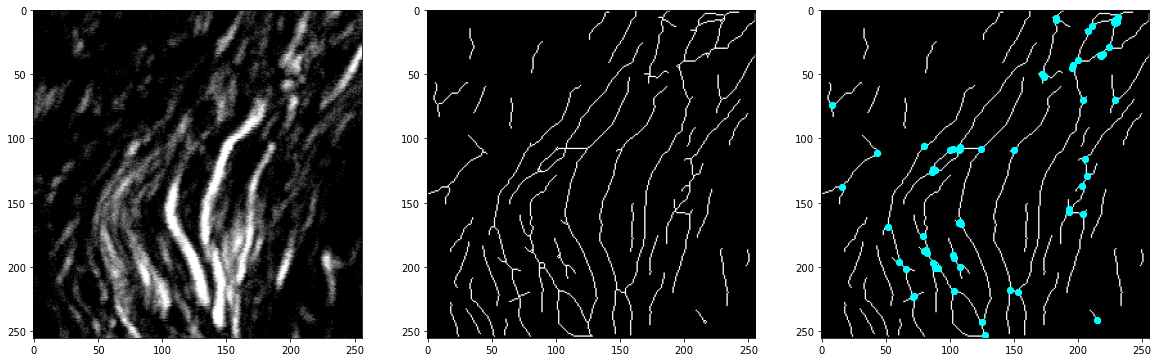

{'cir_mean': -1.4144546600578425, 'cir_var': 0.4933967730955828, 'len_mean': 34.32, 'len_var': 30.43601375563714, 'waviness': 0.34109834393793986, 'intensity': 2679}


In [2]:
mat = sio.loadmat('examples/sample_ctFIRE.mat')
mat_data = mat['data']
centerline_mat = CenterLine()
line_dict = centerline_mat.mat_to_lines(mat_data)
centerline_mat = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_mat.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_mat.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_mat.joint_filter(centerline_mat.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_mat.export_line_dict('examples/example_image_ctFIRE_line_dict.csv')

### compute features from ctFIRE extracted centerline, note that the range of cir_mean is Pi (3.14, 5% error is ~0.15)
centerline_mat.compute_fiber_feats() 
print(dict(list(centerline_mat.feats.items())[:-1]))

### Run ridge detector on a image

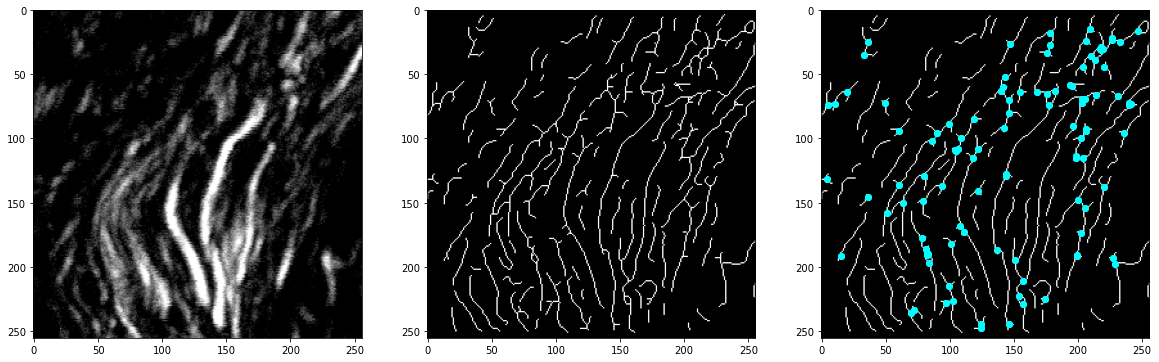

{'cir_mean': -1.3817846443779267, 'cir_var': 0.40030108572793, 'len_mean': 20.706586826347305, 'len_var': 16.265871614156115, 'waviness': 0.3731399013666415, 'intensity': 3672}


In [3]:
centerline_ridge = CenterLine(associate_image=io.imread("examples/sample_input.png"))
line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_ridge.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_ridge.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_ridge.joint_filter(centerline_ridge.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_ridge.export_line_dict('examples/example_image_ridge_line_dict.csv')
centerline_ridge.compute_fiber_feats() 
print(dict(list(centerline_ridge.feats.items())[:-1]))

### Skeletonize a network output

Draw masks using skeletonization


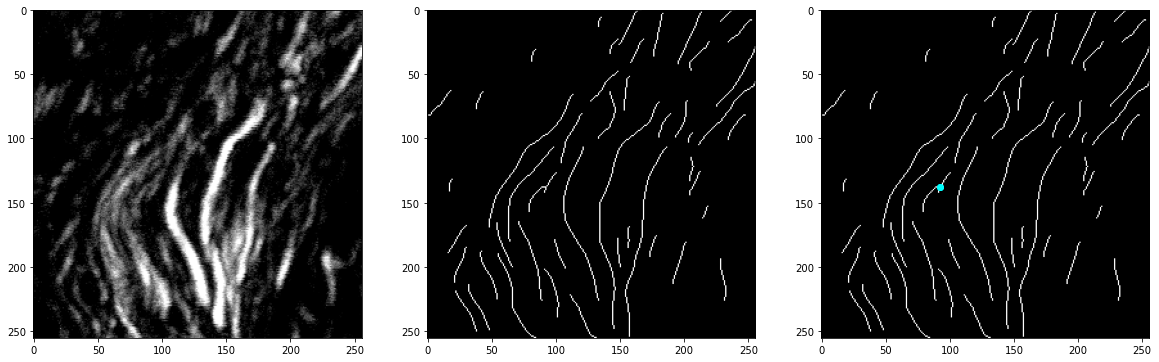

Network results:
{'cir_mean': -1.203951923481333, 'cir_var': 0.2684179136116452, 'len_mean': 37.224489795918366, 'len_var': 34.73530539762422, 'waviness': 0.29830106587327226, 'intensity': 1825}


In [4]:
# vectorization using skimage skeletonization
img = img_as_float( io.imread("examples/sample_network-raw.png") ) # pre-obtained raw network output
binary = img > filters.threshold_otsu((img))
centerline_res = CenterLine(associate_image=binary, draw_from_raw=True)
centerline_res = CenterLine(centerline_image=centerline_res.centerline_image, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Ground truth

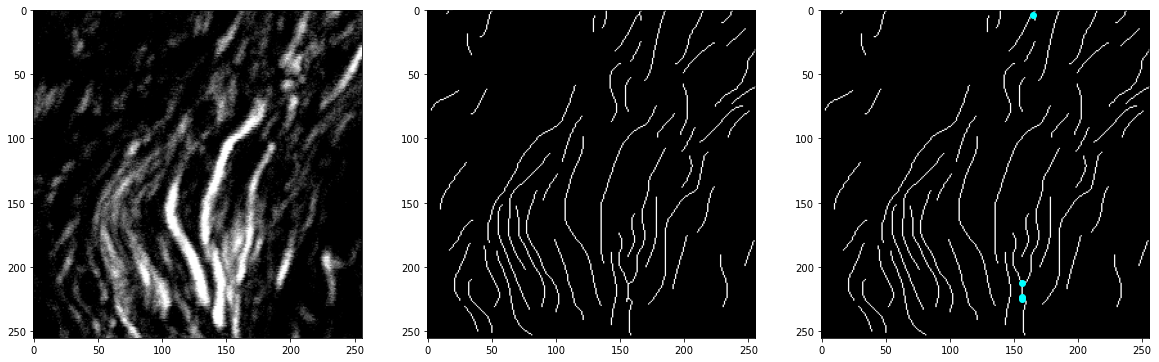

Ground truth:
{'cir_mean': -1.3195425200408986, 'cir_var': 0.3188771778968849, 'len_mean': 45.34615384615385, 'len_var': 32.911235289548515, 'waviness': 0.28158625930238684, 'intensity': 2369}


In [5]:
# Ground truth
centerline = CenterLine(centerline_image=io.imread("examples/sample_groundtruth.png"), associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Ground truth:')
centerline.compute_fiber_feats()
print(dict(list(centerline.feats.items())[:-1]))

### Check IoU and mask differences

ctFIRE
IoU: 0.5513514545973316


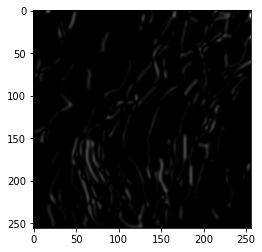

Ridge detector
IoU: 0.5893914963755369


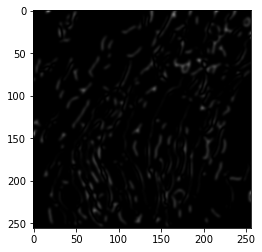

Network
IoU: 0.6264178538655837


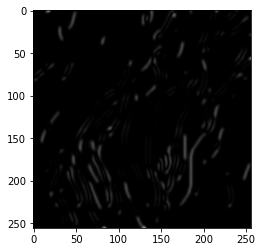

In [6]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_mat.centerline_image), soft=True)
print('ctFIRE')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_ridge.centerline_image), soft=True)
print('Ridge detector')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_res.centerline_image), soft=True)
print('Network')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()

### (Optional) Network output can also be vectorized using ridge detector

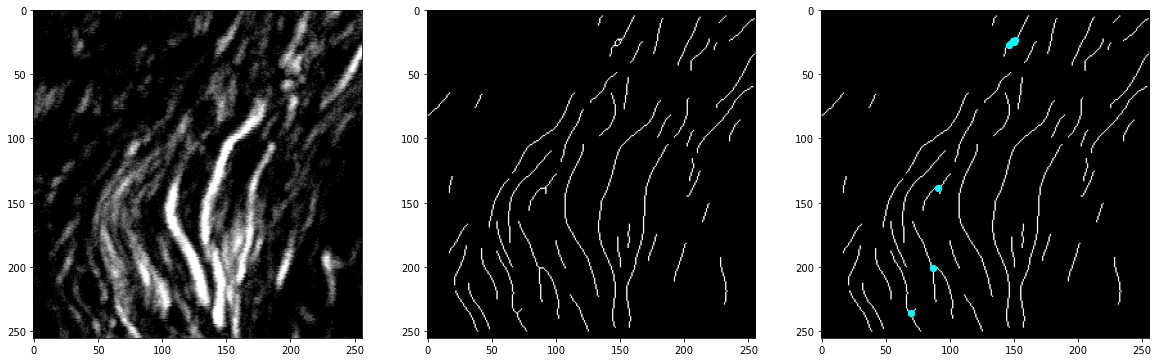

Network results:
{'cir_mean': -1.4296322348993993, 'cir_var': 0.18907691566526452, 'len_mean': 35.254901960784316, 'len_var': 32.65916868966803, 'waviness': 0.29455974662688805, 'intensity': 1808}


In [7]:
# vectorization using ridge detector
img = img_as_float( io.imread("examples/sample_network-raw.png") )
binary = img > filters.threshold_mean((img))
centerline_res = CenterLine(associate_image=binary)
line_dict = centerline_res.ridge_detector(config_fname="ridge_detector_params.json")
centerline_res = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Create extraction results overlay

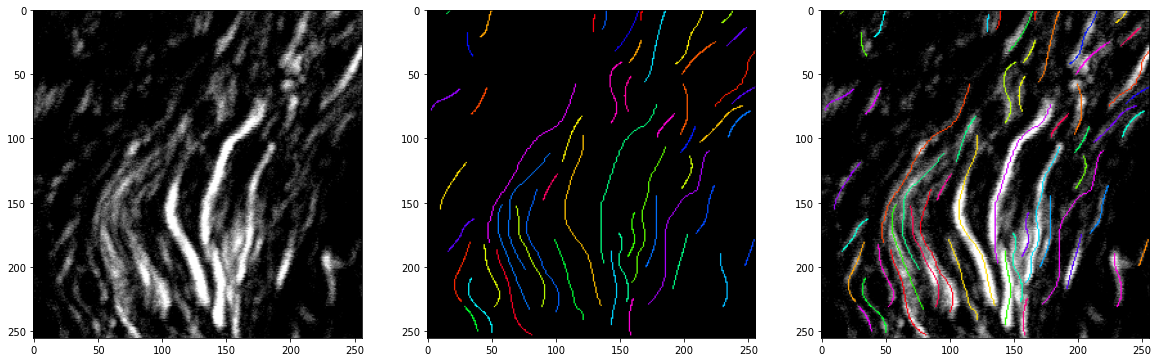

In [8]:
centerline.create_overlay()

### Visualize individual fiber extraction results

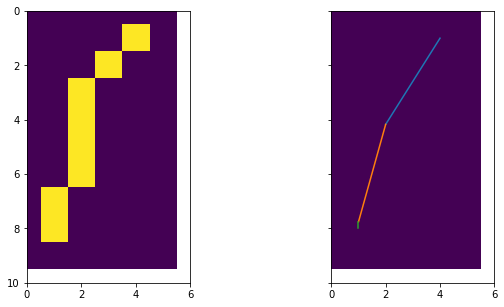

Length: 8.00, Waveiness: 0.3302 



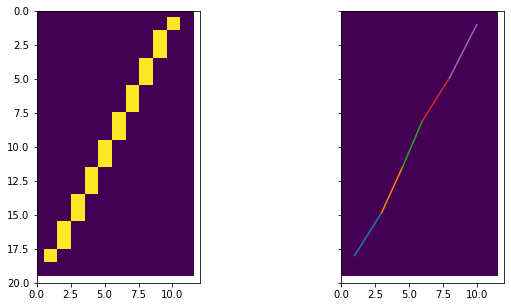

Length: 18.00, Waveiness: 0.3391 



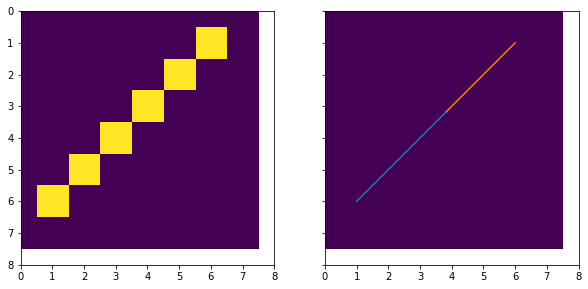

Length: 6.00, Waveiness: 0.0000 



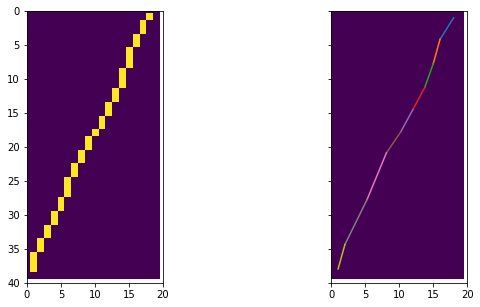

Length: 38.00, Waveiness: 0.3485 



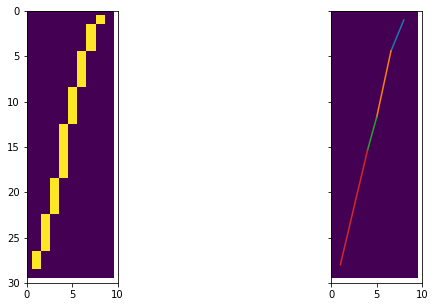

Length: 28.00, Waveiness: 0.3089 



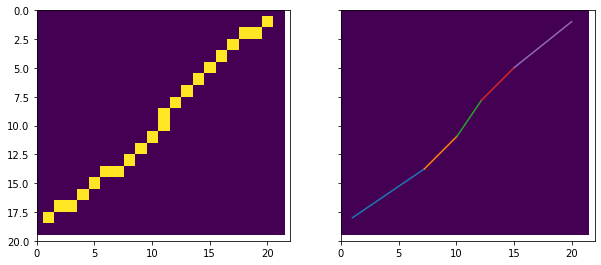

Length: 21.00, Waveiness: 0.1735 



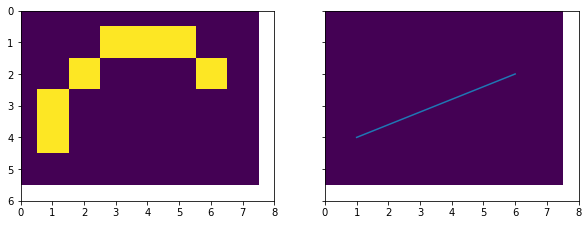

Length: 7.00, Waveiness: 0.0000 



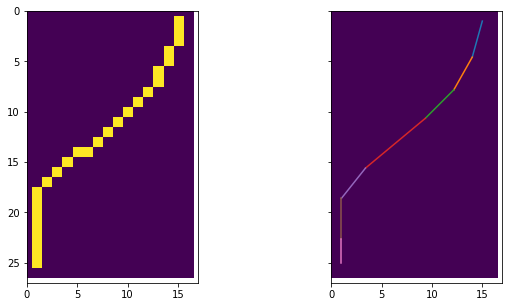

Length: 26.00, Waveiness: 0.2491 



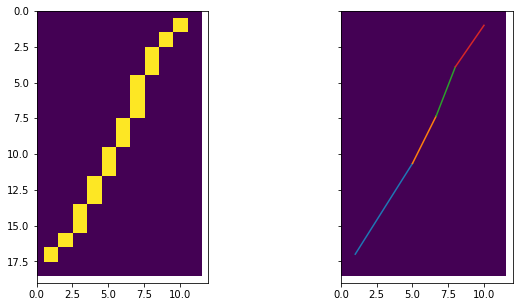

Length: 17.00, Waveiness: 0.3325 



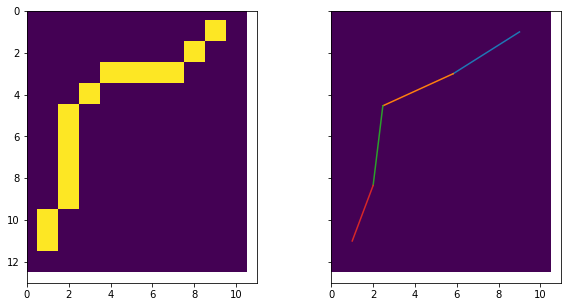

Length: 14.00, Waveiness: 0.5528 



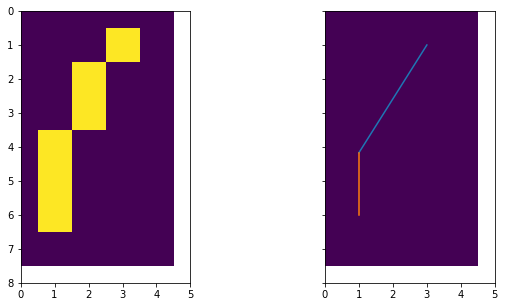

Length: 6.00, Waveiness: 0.2952 



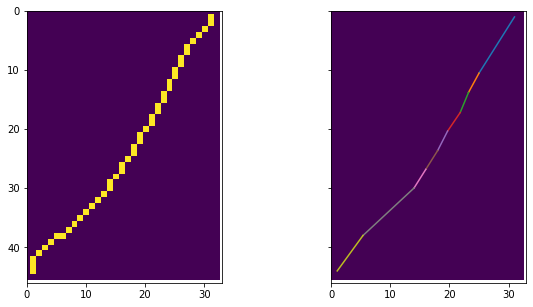

Length: 45.00, Waveiness: 0.2925 



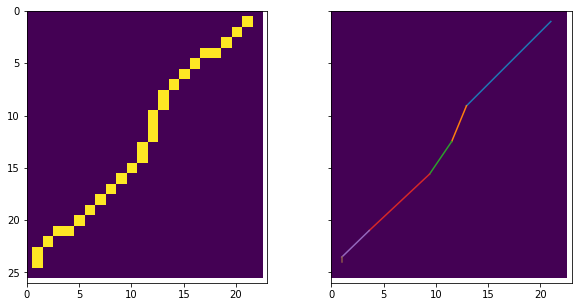

Length: 26.00, Waveiness: 0.2762 



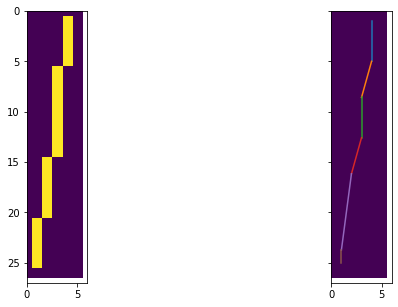

Length: 25.00, Waveiness: 0.2154 



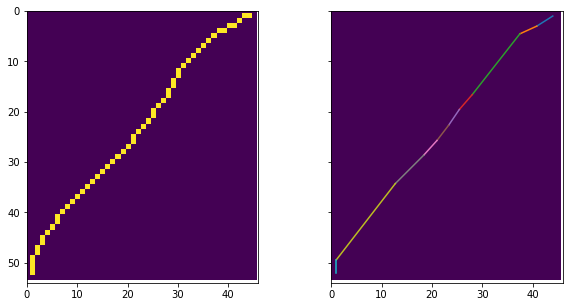

Length: 55.00, Waveiness: 0.2131 



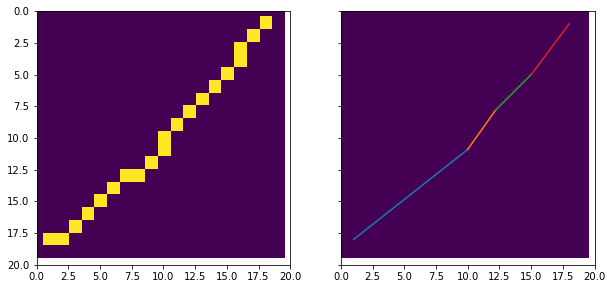

Length: 20.00, Waveiness: 0.1837 



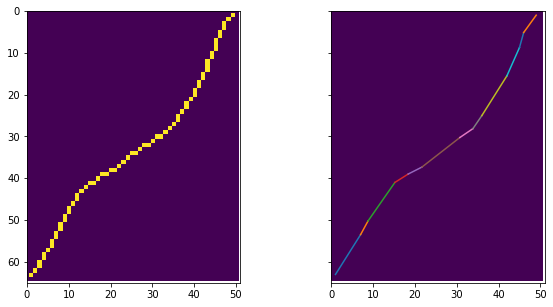

Length: 69.00, Waveiness: 0.3226 



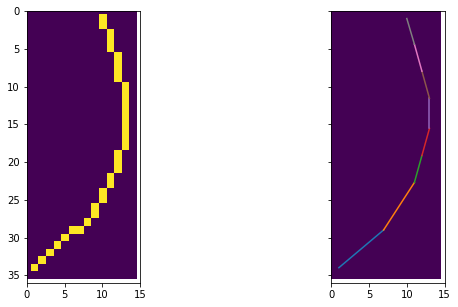

Length: 35.00, Waveiness: 0.3073 



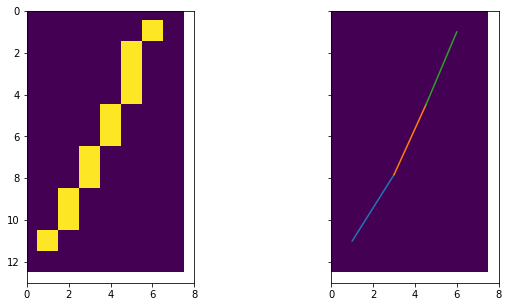

Length: 11.00, Waveiness: 0.3308 



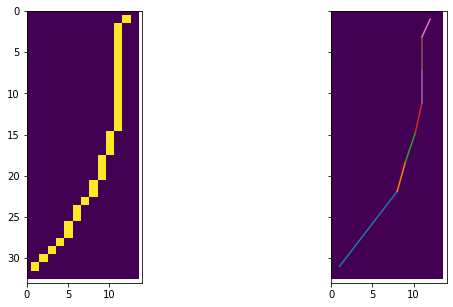

Length: 31.00, Waveiness: 0.2391 



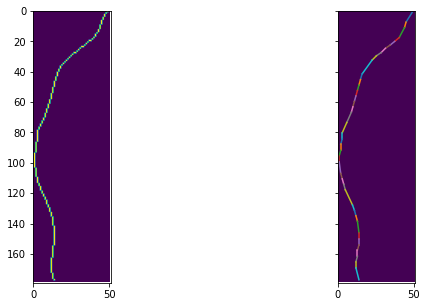

Length: 180.00, Waveiness: 0.2736 



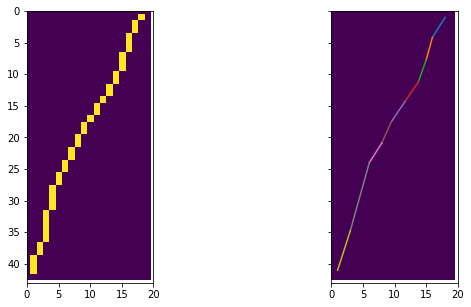

Length: 41.00, Waveiness: 0.3390 



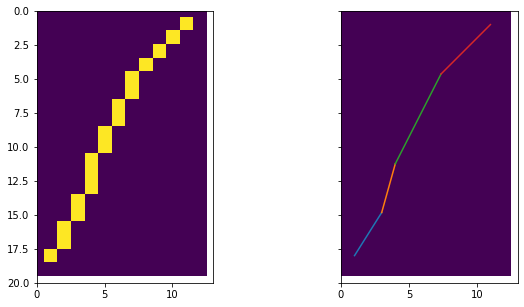

Length: 18.00, Waveiness: 0.3255 



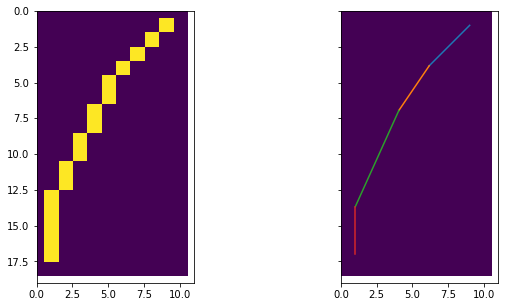

Length: 17.00, Waveiness: 0.2982 



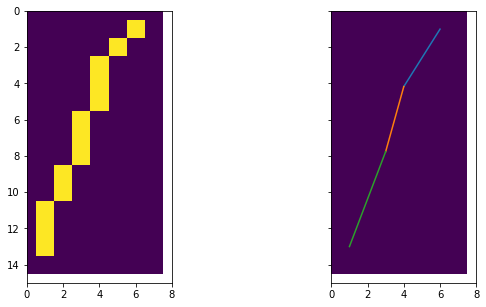

Length: 13.00, Waveiness: 0.3383 



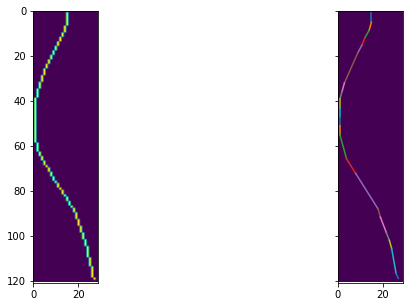

Length: 119.00, Waveiness: 0.2856 



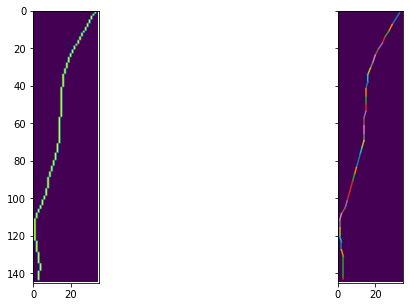

Length: 143.00, Waveiness: 0.2590 



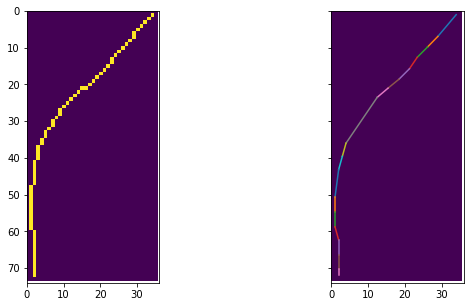

Length: 73.00, Waveiness: 0.1682 



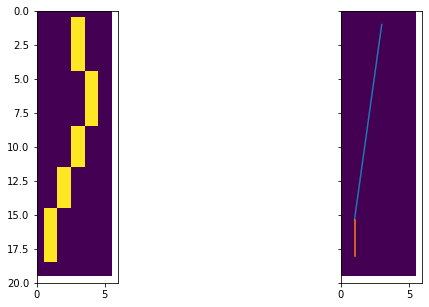

Length: 18.00, Waveiness: 0.3186 



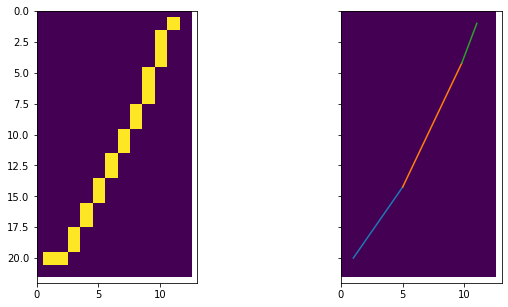

Length: 21.00, Waveiness: 0.3975 



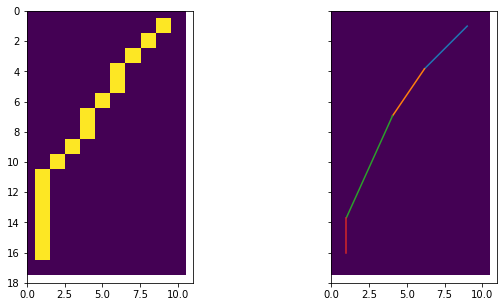

Length: 16.00, Waveiness: 0.3000 



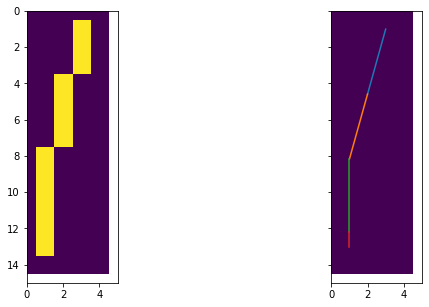

Length: 13.00, Waveiness: 0.2009 



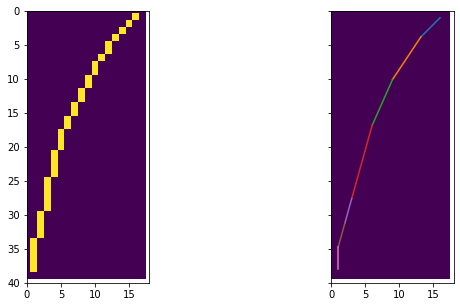

Length: 38.00, Waveiness: 0.3101 



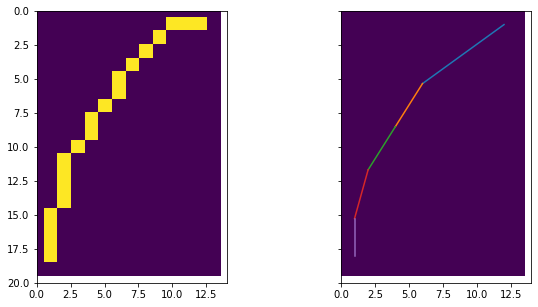

Length: 20.00, Waveiness: 0.3407 



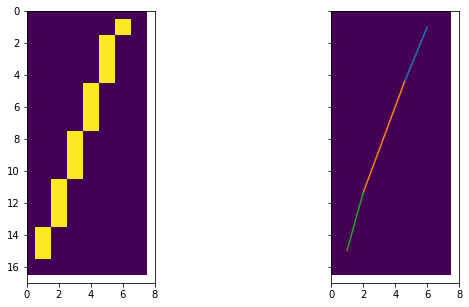

Length: 15.00, Waveiness: 0.3400 



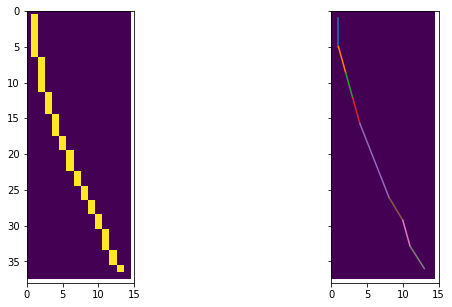

Length: 36.00, Waveiness: 0.3320 



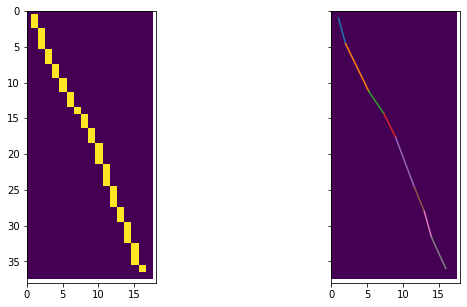

Length: 36.00, Waveiness: 0.3503 



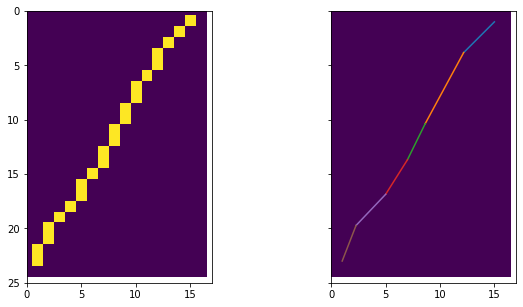

Length: 23.00, Waveiness: 0.2916 



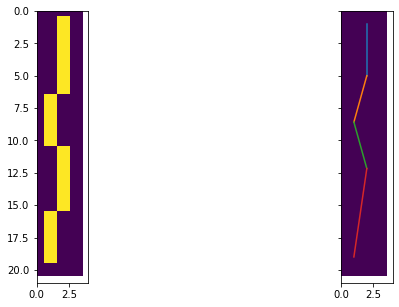

Length: 19.00, Waveiness: 0.3404 



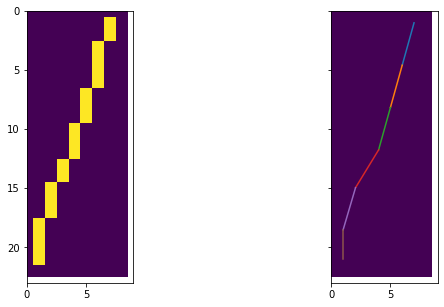

Length: 21.00, Waveiness: 0.3354 



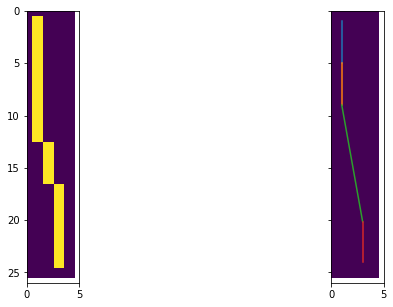

Length: 24.00, Waveiness: 0.1560 



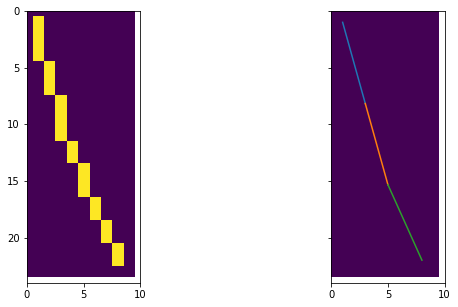

Length: 22.00, Waveiness: 0.3277 



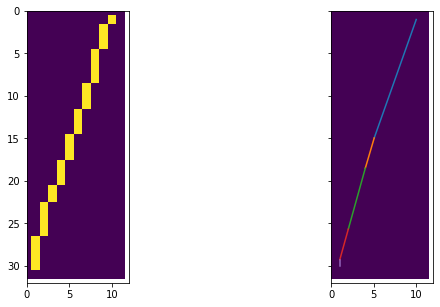

Length: 30.00, Waveiness: 0.3262 



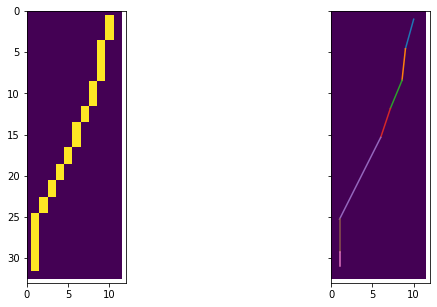

Length: 31.00, Waveiness: 0.3125 



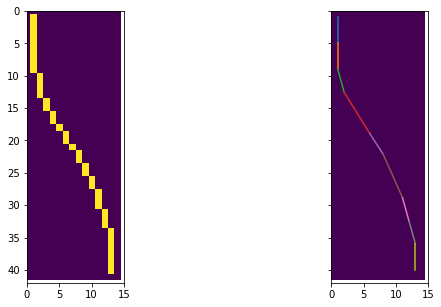

Length: 40.00, Waveiness: 0.2905 



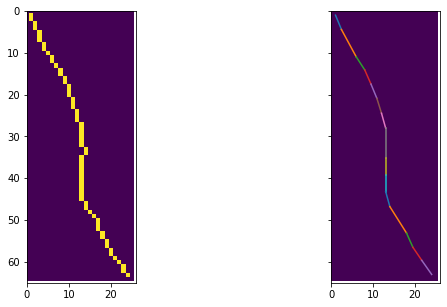

Length: 63.00, Waveiness: 0.3240 



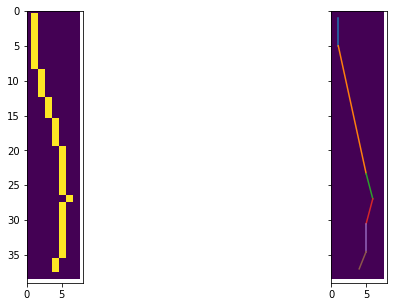

Length: 37.00, Waveiness: 0.3063 



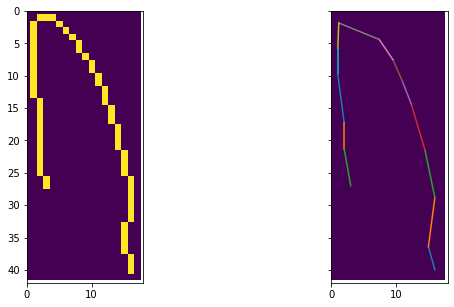

Length: 68.00, Waveiness: 0.5391 



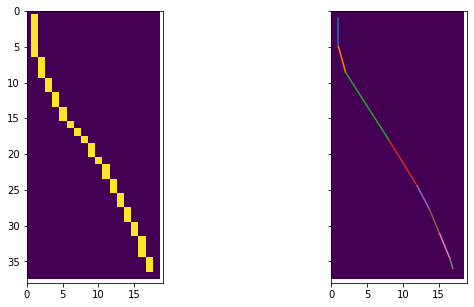

Length: 36.00, Waveiness: 0.3319 



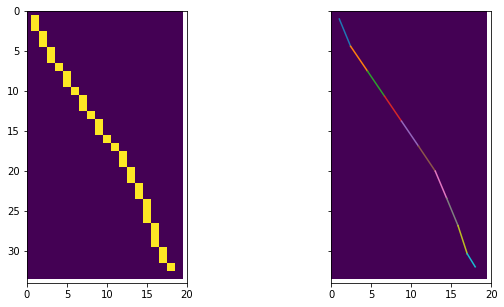

Length: 32.00, Waveiness: 0.3164 



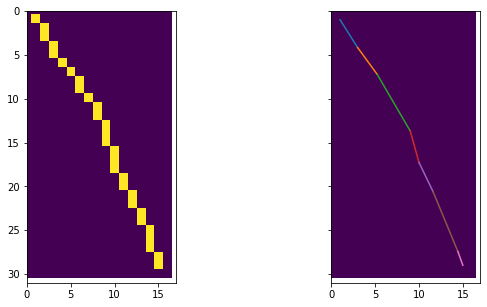

Length: 29.00, Waveiness: 0.3367 



In [26]:
centerline = centerline_res

for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1: fragments = [shape_line]
    else: fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waveiness: {waviness:.4f} \n')